# Chapter 11 Image Segmentation

This is the companion file for Chapter 11.

## Programming exercise 11.1:

1.   Run the following code to perform Split-and-Merge Clustering.

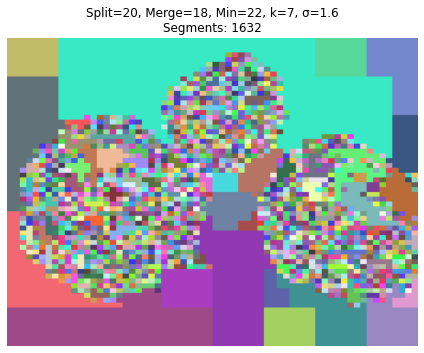

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

class Region:
    def __init__(self, x, y, w, h, image):
        self.x, self.y, self.w, self.h = x, y, w, h
        patch = image[y:y+h, x:x+w]
        self.n = w * h
        self.sum = float(np.sum(patch))
        self.sum_sq = float(np.sum(patch.astype(np.float64)**2))
        self.update_stats()

    def update_stats(self):
        self.mean = self.sum / self.n
        var = (self.sum_sq - (self.sum**2)/self.n) / self.n
        self.var = max(0.0, var)
        self.std = np.sqrt(self.var)

def are_adjacent(r1, r2):
    vert = ((r1.x + r1.w == r2.x or r2.x + r2.w == r1.x)
            and not (r1.y + r1.h <= r2.y or r2.y + r2.h <= r1.y))
    horz = ((r1.y + r1.h == r2.y or r2.y + r2.h == r1.y)
            and not (r1.x + r1.w <= r2.x or r2.x + r2.w <= r1.x))
    return vert or horz

def split_pass(region, split_threshold, min_size, image):
    if region.std <= split_threshold or region.w <= min_size or region.h <= min_size:
        return [region]
    hw, hh = region.w // 2, region.h // 2
    quads = [
        (region.x, region.y, hw, hh),
        (region.x+hw, region.y, region.w-hw, hh),
        (region.x, region.y+hh, hw, region.h-hh),
        (region.x+hw, region.y+hh, region.w-hw, region.h-hh),
    ]
    leaves = []
    for x, y, w, h in quads:
        if w > 0 and h > 0:
            leaves.extend(split_pass(Region(x, y, w, h, image), split_threshold, min_size, image))
    return leaves

def build_adjacency(regions):
    adj = [[] for _ in regions]
    for i in range(len(regions)):
        for j in range(i+1, len(regions)):
            if are_adjacent(regions[i], regions[j]):
                adj[i].append(j)
                adj[j].append(i)
    return adj

def merge_pass(regions, merge_threshold):
    parent = list(range(len(regions)))
    stats = [{'n': r.n, 'sum': r.sum, 'sum_sq': r.sum_sq} for r in regions]
    adj = build_adjacency(regions)

    def find(u):
        if parent[u] != u:
            parent[u] = find(parent[u])
        return parent[u]

    def union(u, v):
        ru, rv = find(u), find(v)
        if ru == rv:
            return False
        if ru > rv:
            ru, rv = rv, ru
        parent[rv] = ru
        s1, s2 = stats[ru], stats[rv]
        s1['n'] += s2['n']
        s1['sum'] += s2['sum']
        s1['sum_sq'] += s2['sum_sq']
        return True

    changed = True
    while changed:
        changed = False
        for i, nbrs in enumerate(adj):
            for j in nbrs:
                if i >= j:
                    continue
                ri, rj = find(i), find(j)
                if ri != rj:
                    s1, s2 = stats[ri], stats[rj]
                    n = s1['n'] + s2['n']
                    var = (s1['sum_sq'] + s2['sum_sq'] - (s1['sum'] + s2['sum'])**2 / n) / n
                    if np.sqrt(max(0, var)) <= merge_threshold:
                        if union(ri, rj):
                            changed = True

    groups = {}
    for idx, r in enumerate(regions):
        root = find(idx)
        groups.setdefault(root, []).append(r)
    return list(groups.values())

def visualize_segments(groups, shape):
    seg = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)
    for group in groups:
        color = np.random.randint(50, 255, 3)
        for reg in group:
            seg[reg.y:reg.y+reg.h, reg.x:reg.x+reg.w] = color
    return seg

def run_segmentation(gray_img, split_th, merge_th, min_sz):
    root = Region(0, 0, gray_img.shape[1], gray_img.shape[0], gray_img)
    leaves = split_pass(root, split_th, min_sz, gray_img)
    groups = merge_pass(leaves, merge_th)
    seg_img = visualize_segments(groups, gray_img.shape)
    return seg_img, len(groups)

# Parameters (adjust as needed)
split_th = 20
merge_th = 18
min_sz = 22
kernel_sz = 7
sigma = 1.6

# Ensure kernel size is odd
if kernel_sz % 2 == 0:
    kernel_sz += 1

# Load and process image
img = cv2.imread("images/input_split_merge.jpg")
if img is None:
    raise FileNotFoundError("image not found in current directory")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (kernel_sz, kernel_sz), sigma)

# Run segmentation
seg_img, seg_count = run_segmentation(blurred, split_th, merge_th, min_sz)

# Show result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
plt.title(f"Split={split_th}, Merge={merge_th}, Min={min_sz}, k={kernel_sz}, σ={sigma}\nSegments: {seg_count}")
plt.axis('off')
plt.tight_layout()
plt.show()


## **Video 11.1**
**k-Means Clustering Algorithm.**

[![K-MEANS Clustering Algorithm](https://img.youtube.com/vi/5I3Ei69I40s/0.jpg)](https://www.youtube.com/watch?v=5I3Ei69I40s)

*Video 1: K-MEANS Clustering Algorithm.*


## Programming exercise 11.2:

1.   Run the following code to perform k-Means Clustering.

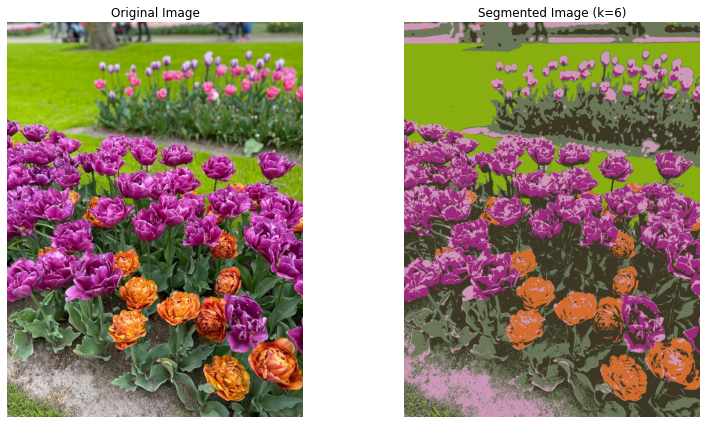

In [1]:
#K-means

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k = 6  # You can change this to any number of segments you want

# Load the image
image_bgr = cv2.imread('images/tulip2.jpeg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# Define criteria for K-means (type, max_iter, epsilon)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# Apply K-means clustering
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert centers to uint8 (color values)
centers = np.uint8(centers)

# Map each pixel to the color of its corresponding center
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_rgb.shape)

# Plot the original and segmented images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Segmented Image (k={k})')
plt.imshow(segmented_image)
plt.axis('off')

plt.tight_layout()
plt.show()


## Programming exercise 11.3:

1.   Run the following code to perform Meanshift Clustering.

Original image shape: (1600, 1200, 3)
Estimated bandwidth: 49.78323383001994
Number of estimated clusters: 4


<Figure size 864x432 with 0 Axes>

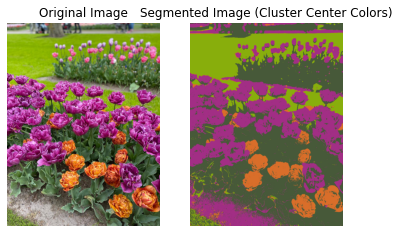

In [17]:
#Meanshift
import numpy as np
import cv2
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Load image 
image_bgr = cv2.imread('images/tulip2.jpeg')  # BGR format
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Store original shape (Height, Width, Channels)
original_shape = image_rgb.shape
print("Original image shape:", original_shape)

# Flatten image to shape (num_pixels, 3) for clustering
X = image_rgb.reshape(-1, 3)

# Estimate bandwidth and apply MeanShift clustering 
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=100)
print("Estimated bandwidth:", bandwidth)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_  # Label for each pixel
cluster_centers = ms.cluster_centers_  # RGB color for each cluster center
n_clusters = len(np.unique(labels))
print("Number of estimated clusters:", n_clusters)

# Reconstruct segmented image using cluster center colors
segmented_flat = cluster_centers[labels]  # shape: (H*W, 3)
segmented_image = segmented_flat.reshape(original_shape)  # shape: (H, W, 3)
segmented_image = np.clip(segmented_image, 0, 255).astype(np.uint8)

# Plot the original and segmented images side by side
plt.figure(figsize=(12, 6))

# Display segmented image
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image (Cluster Center Colors)")
plt.axis('off')
plt.show()




## **Video 11.2**
**Mean Shift**

In [19]:
from IPython.display import HTML

HTML("""
<video width="600" controls autoplay>
  <source src="https://raw.githubusercontent.com/hazalmogultay/466Images/master/W12/mscm.mp4" type="video/mp4">
</video>
<p>Video 2: Mean Shift</p>
""")


## **Video 11.3**
**What is Mean Shift?**

In [20]:
from IPython.display import HTML

HTML("""
<video width="400" controls>
  <source src="https://raw.githubusercontent.com/hazalmogultay/466Images/master/W12/What_is_Mean_Shift.mp4" type="video/mp4">
</video>
<p>Video 3: What is Mean Shift?</p>
""")


## Programming exercise 11.4: 

1.   Run the following code to perform segmentation using thresholding.
2.   Change the threshold and see how the output changes.

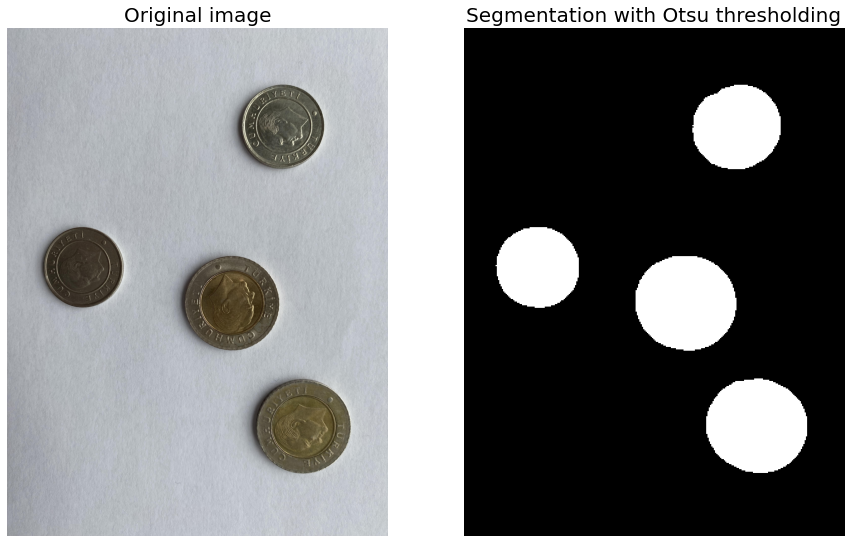

In [4]:
## Segmentation using thresholding
#Segment the coins to obtain a binary image where pixels representing the coins are set to 1.

from skimage import io, color
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage.morphology import disk
from skimage.filters.rank import median
from skimage.transform import rescale
import numpy as np
from skimage import img_as_ubyte


# Load image and convert it to grayscale
!wget -cq https://raw.githubusercontent.com/hazalmogultay/466Images/master/W12/coins.jpeg
im = io.imread('coins.jpeg')
im_g = color.rgb2gray(im)
im_g = rescale(im_g, 0.1, anti_aliasing=False)

# Apply median filter
im_g = median(img_as_ubyte(im_g), disk(3))

# Find the threshold and perform segmentation
thresh = threshold_otsu(im_g)
binary = im_g > thresh

# Swap pixel values
swapped_binary = np.zeros_like(binary)
swapped_binary[binary == False] = 1

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(im, cmap="gray");
plt.title("Original image", fontsize=20);
plt.axis("off");


plt.subplot(122)
plt.imshow(swapped_binary, cmap="gray");
plt.title("Segmentation with Otsu thresholding", fontsize=20);
plt.axis("off");



## **Video 11.4**
**Finding Clusters in Graphs by Gilbert Strang**

[![Finding Clusters in Graphs](https://img.youtube.com/vi/cxTmmasBiC8/0.jpg)](https://www.youtube.com/watch?v=cxTmmasBiC8)

*Video 4:Finding Clusters in Graphs*


## **Video 11.5**
**Graph Similarity Matrix by Shi**

In [21]:
from IPython.display import HTML

HTML("""
<video width="400" controls autoplay>
  <source src="https://raw.githubusercontent.com/hazalmogultay/466Images/master/W12/shi.mp4" type="video/mp4">
</video>
<p>Video 5: Graph Similarity Matrix</p>
""")


## **Video 11.6**
**Graph-based Image Segmentation**

In [22]:
%%HTML
<video width="400" controls autoplay>
  <source src="https://raw.githubusercontent.com/hazalmogultay/466Images/master/W12/GraphSegmentation.mp4" type="video/mp4">
</video>
<p>
Video 6: Graph-based Image Segmentation 
</p>


## Programming exercise 11.5: 

1.   Run the following code to obtain superpixels and normalize cut to merge superpixels.
2.   Change compactness and number of segments parameters and observe how the superpixels change.

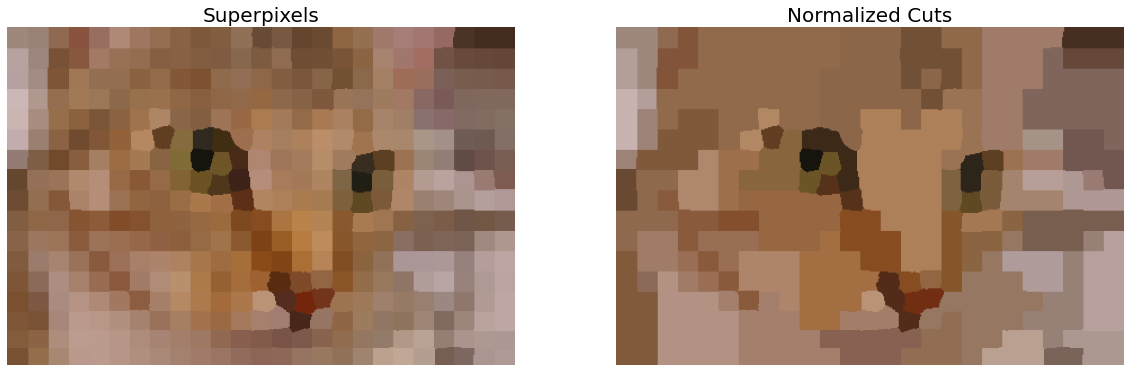

In [14]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import numpy as np
from skimage import io, feature, color
from skimage.transform import rescale

img = data.chelsea()

# Generate superpixels using SLIC algorithm that segments image using k-means clustering in Color-(x,y,z) space
segments = segmentation.slic(img, compactness=100, n_segments=400)
superpixels = color.label2rgb(segments, img, kind='avg')

# Create a Region Adjacency Graph. Each node is a superpixel and the weight between adjacent superpixels represents how similar two regions are.
g = graph.rag_mean_color(img, segments, mode='similarity')

# Perform a normalized cut 
graph_cut_segments = graph.cut_normalized(segments, g, thresh=0.1)
nc = color.label2rgb(graph_cut_segments, img, kind='avg', bg_label=0)


plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(superpixels.astype('int'));
plt.axis('off');
plt.title('Superpixels', fontsize=20);

plt.subplot(122)
plt.imshow(nc);
plt.axis('off');
plt.title('Normalized Cuts', fontsize=20);

## Programming exercise 11.6: 

1.  Run the following code to see how the accumulator array changes when new points are added to the image.

Text(0, 0.5, 'nrho')

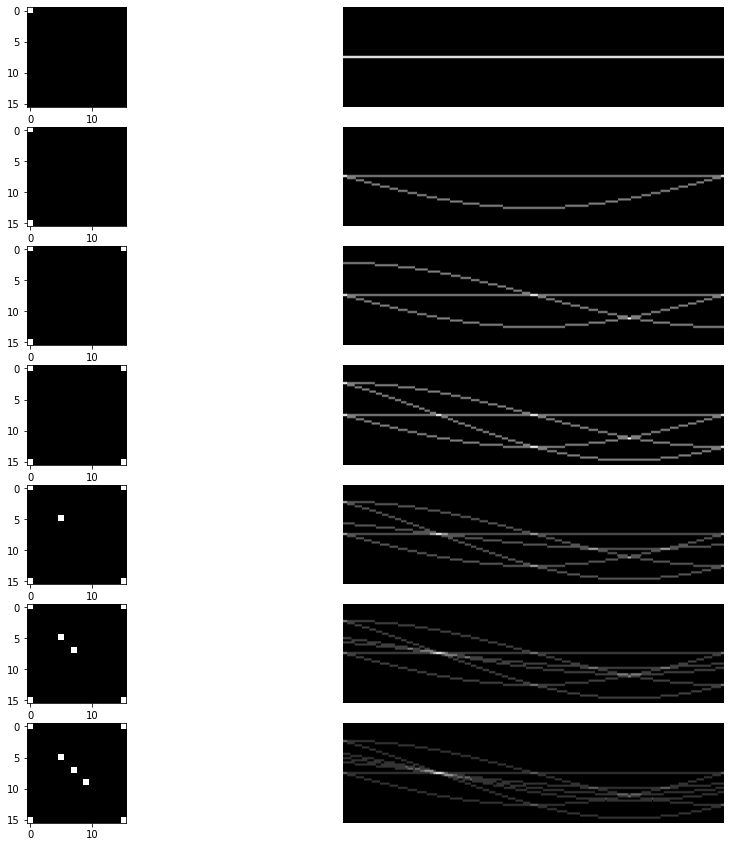

In [25]:
# Hough transform
import numpy as np
from skimage.transform import hough_line

tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
im =  np.zeros((16,16))
# Put the first white point
im[0,0]=1
#Transpose image to swap x and y axes before inputting it to hough_line function since this function accepts x and y as horizontal and vertical edges respectively.
#However, in xy-plane, x is the vertical edge and y is the horizontal edge.
H, theta, d=hough_line(im.T, theta =tested_angles)
# H is the accumulator array
angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
# Plot accumulator array with the given bounds
plt.figure(figsize=(15,15))
plt.subplot(721), plt.imshow(im, cmap='gray') 
plt.subplot(722), 
plt.imshow(H, extent=bounds, cmap='gray')
plt.axis('off')
########################
# Put the second white point
im[15,0]=1
H, theta, d=hough_line(im.T, theta =tested_angles)
plt.subplot(723), plt.imshow(im, cmap='gray') 


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.subplot(724), 
plt.imshow(H, extent = bounds, cmap='gray')
plt.axis('off')

########################
# Put the third white point
im[0,15]=1
H, theta, d=hough_line(im.T, theta =tested_angles)
plt.subplot(725), plt.imshow(im, cmap='gray') 


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.subplot(726), 
plt.imshow(H, extent = bounds, cmap='gray')
plt.axis('off')

########################
# Put the fourth white point
im[15,15]=1
H, theta, d=hough_line(im.T, theta =tested_angles)
plt.subplot(727), plt.imshow(im, cmap='gray') 


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.subplot(728), 
plt.imshow(H, extent = bounds, cmap='gray')
plt.axis('off')

##################
# Put the fifth white point
im[5,5]=1
H, theta, d=hough_line(im.T, theta =tested_angles)
plt.subplot(729), plt.imshow(im, cmap='gray') 


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.subplot(7,2,10), 
plt.imshow(H, extent = bounds, cmap='gray')
plt.axis('off')

##################
# Put the sixth white point
im[7,7]=1
H, theta, d=hough_line(im.T, theta =tested_angles)
plt.subplot(7,2,11), plt.imshow(im, cmap='gray') 


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.subplot(7,2,12), 
plt.imshow(H, extent = bounds, cmap='gray')
plt.axis('off')
plt.xlabel('ntheta')
plt.ylabel('nrho')

####################
# Put the seventh white point
im[9,9]=1
H, theta, d=hough_line(im.T, theta =tested_angles)
plt.subplot(7,2,13), plt.imshow(im, cmap='gray') 


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

plt.subplot(7,2,14), 
plt.imshow(H, extent = bounds, cmap='gray')
plt.axis('off')
plt.xlabel('ntheta')
plt.ylabel('nrho')

## Programming exercise 11.7: 

1.  Run the following code to detect the coins (circles) in the image.

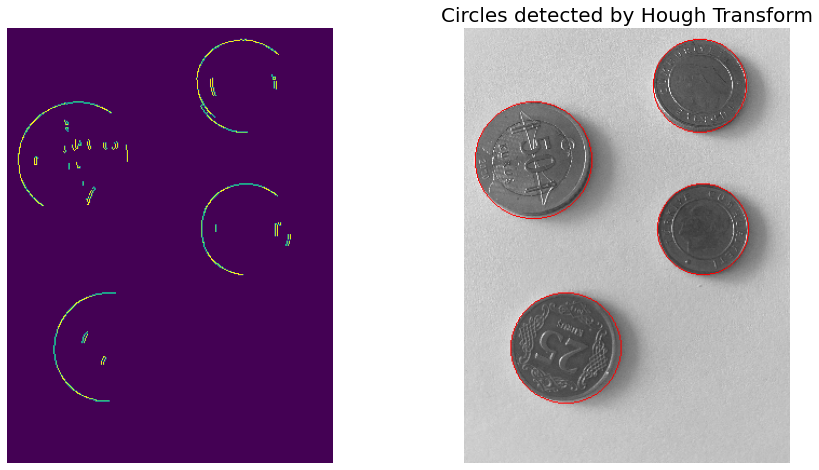

In [26]:
# Hough transform for detecting circles
from skimage import feature, io, color
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.transform import rescale

# Load image and rescale it
!wget -cq https://raw.githubusercontent.com/hazalmogultay/466Images/master/W13/paralar.jpeg
image = img_as_ubyte(color.rgb2gray(io.imread('paralar.jpeg')))
image = rescale(image, 0.1, anti_aliasing=False)

# Detect edges using Canny edge detector
edges = feature.canny(image, sigma=0.3, low_threshold=1, high_threshold=2)

# Define a set of radii and run hough circle detector 
hough_radii = np.arange(20, 60, 1)
hough_res = hough_circle(edges, hough_radii)

# Select 4 circles (there are 4 coins in the image)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,total_num_peaks=4)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (1, 0, 0)

plt.title('Circles detected by Hough Transform', fontsize=20 )
ax[0].imshow(edges)
ax[0].axis('off')
ax[1].imshow(image, cmap=plt.cm.gray)
plt.axis('off')
plt.show()